# Neurogenesis

In [1]:
import getopt
import pandas as pd
import numpy as np
import pickle
import os
import sys 
import phlower
import scanpy as sc
from datetime import datetime
from matplotlib import pyplot as plt 
from collections import Counter

In [2]:
## from scvelo.datasets.pancreas()
print(datetime.now(),"loading...")
adata = sc.read_h5ad("data/DentateGyrus/DentateGyrus.h5ad")
adata = phlower.dataset.neurogenesis()
adata.var_names_make_unique()

print(datetime.now(),"mt...")
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

2025-01-14 15:52:33.429898 loading...
2025-01-14 15:52:34.920234 mt...


In [3]:
print(datetime.now(),"preprocessing...")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

print(datetime.now(),"pca...")
sc.tl.pca(adata, svd_solver="arpack")

adata.obs['group'] = adata.obs['clusters']

2025-01-14 15:52:35.494529 preprocessing...
2025-01-14 15:53:05.777980 pca...


In [4]:
phlower.ext.ddhodge(adata, basis='X_pca', roots=(adata.obs.group=="nIPC"), k=12, npc=40,ndc=5,s=1, verbose=True)

2025-01-14 15:53:08.446259 distance_matrix
2025-01-14 15:53:41.729824 Diffusionmaps: 
done.
2025-01-14 15:55:10.265315 diffusion distance:
2025-01-14 15:55:21.895666 transition matrix:
2025-01-14 15:55:34.563674 graph from A
2025-01-14 15:55:35.451916 Rewiring: 
2025-01-14 15:55:35.452000 div(g_o)...
2025-01-14 15:57:24.801157 edge weight...
2025-01-14 15:57:28.130695 cholesky solve ax=b...
+ 1e-06 I is positive-definite
2025-01-14 15:58:57.280354 grad...
2025-01-14 16:17:55.681036 potential.
2025-01-14 16:36:47.933767 ddhodge done.
done.
2025-01-14 16:36:49.143244 calculate layouts
2025-01-14 17:33:56.925509 done


In [5]:
phlower.tl.construct_delaunay_persistence(adata, start_n=10, end_n=10, circle_quant=0.7, min_persistence=0.1)

start clusters  ['CA', 'Granule', 'CA2-3-4', 'RadialGlia', 'ImmAstro', 'ImmGranule2', 'OPC', 'ImmGranule1', 'Nbl2', 'nIPC', 'RadialGlia2', 'Nbl1', 'CA1-Sub', 'GlialProg']
end clusters  ['CA', 'Granule', 'CA2-3-4', 'RadialGlia', 'ImmAstro', 'ImmGranule2', 'OPC', 'ImmGranule1', 'Nbl2', 'nIPC', 'RadialGlia2', 'Nbl1', 'CA1-Sub']


<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

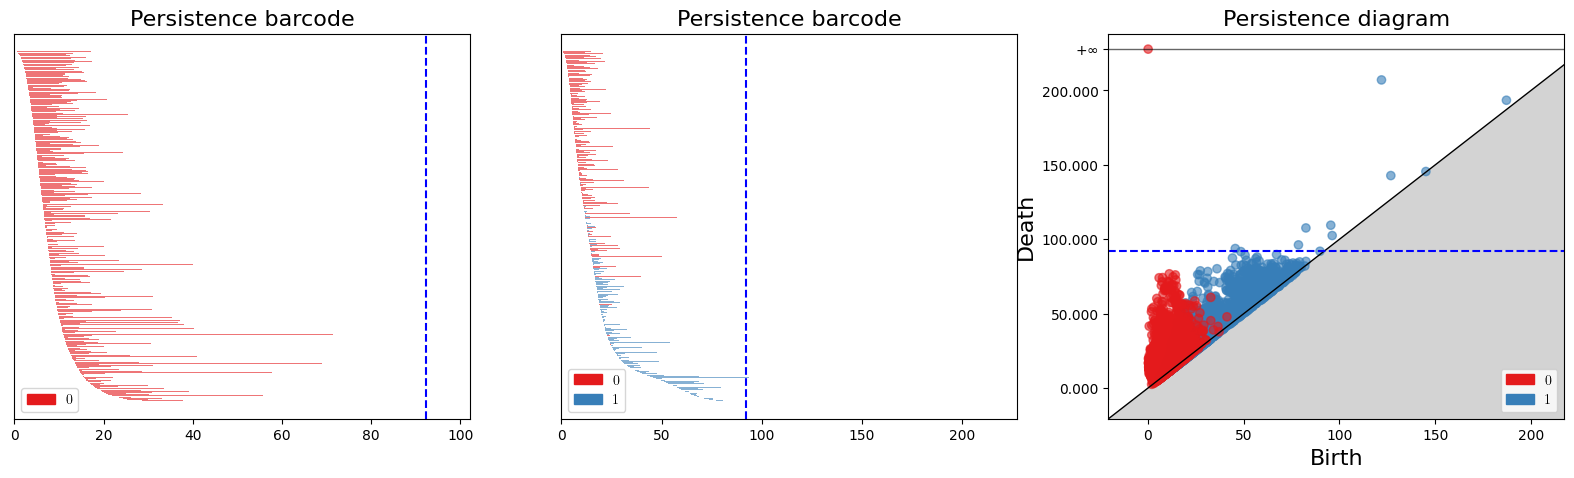

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
phlower.pl.persisitence_barcodes(adata, ax=axes[0], include_holes=False, barcodes_dim=[0])
phlower.pl.persisitence_barcodes(adata, ax=axes[1], include_holes=False, barcodes_dim=[0,1])
phlower.pl.persisitence_birth_death(adata, ax=axes[2], include_holes=False)

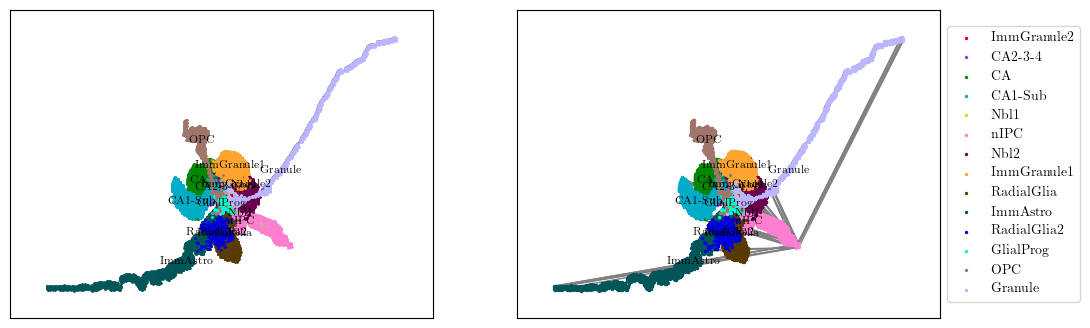

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
phlower.pl.nxdraw_group(adata, layout_name='X_pca_ddhodge_g', graph_name='X_pca_ddhodge_g_triangulation', node_size=1, show_edges=True, ax=ax[0], show_legend=False, labelstyle='text', labelsize=8)
phlower.pl.nxdraw_group(adata, layout_name='X_pca_ddhodge_g', graph_name='X_pca_ddhodge_g_triangulation_circle', node_size=2, show_edges=True, ax=ax[1], show_legend=True, labelstyle='text', labelsize=8)

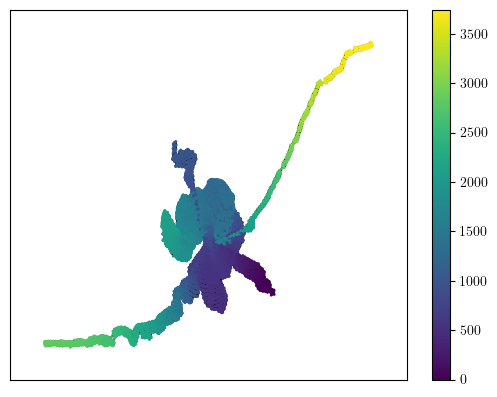

In [8]:
phlower.pl.nxdraw_score(adata, layout_name='X_pca_ddhodge_g', graph_name='X_pca_ddhodge_g_triangulation', node_size=1)

## Hodge decomposition

In [9]:
from datetime import datetime 

dt1 = datetime.now() 
print('L1 Datetime Start:', dt1) 

phlower.tl.L1Norm_decomp(adata, L1_mode='sym', check_symmetric=False, isnorm = True) 
dt2 = datetime.now() 
print('L1 Datetime End:', dt2) 
delta = dt2 - dt1 
print('L1 Difference is:', delta) 

L1 Datetime Start: 2025-01-14 17:34:46.617858
3599.1217019557953  sec
L1 Datetime End: 2025-01-14 18:34:47.351646
L1 Difference is: 1:00:00.733788


## determine harmonic

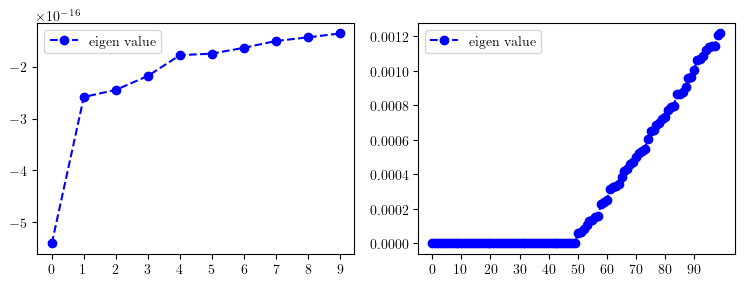

In [10]:
_, ax = plt.subplots(1,2, figsize=(9,3))
phlower.pl.plot_eigen_line(adata, n_eig=10,ax=ax[0])
phlower.pl.plot_eigen_line(adata, n_eig=100, step_size=10, ax=ax[1]) 

In [11]:
phlower.tl.knee_eigen(adata) 

knee eigen value is  50


## preference random walk

In [12]:
phlower.tl.random_climb_knn(adata, n=10000, roots_ratio=0.001, knn_edges_k=16, knn_type='diffusion')

100%|██████████| 10000/10000 [01:38<00:00, 101.81it/s]


## Project paths to harmonic space

In [13]:
phlower.tl.trajs_matrix(adata)

2025-01-14 18:38:49.683893 projecting trajectories to simplics...
2025-01-14 18:39:40.052710 Embedding trajectory harmonics...
eigen_n < 1, use knee_eigen to find the number of eigen vectors to use: 50


/home/sz753404/miniconda3/envs/R422/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2025-01-14 18:40:24.916227 done.


## Paths clustering

In [14]:
phlower.tl.trajs_clustering(adata, eps=0.3, oname_basis='') 

In [15]:
Counter(adata.uns['trajs_clusters'])

Counter({0: 8297, 1: 1044, 2: 484, 4: 97, -1: 49, 3: 19, 5: 10})

In [16]:
phlower.tl.unique_trajectory_clusters(adata,verbose=False)

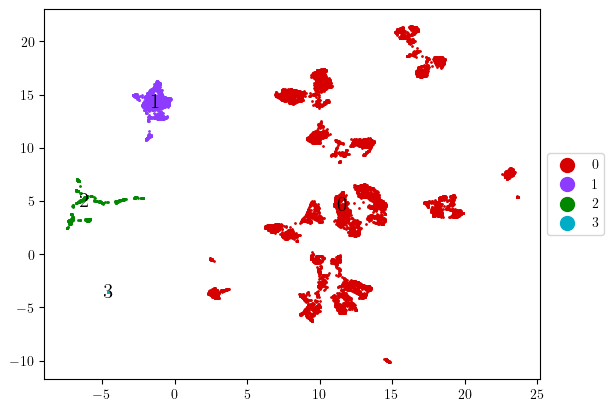

In [17]:
phlower.pl.plot_trajs_embedding(adata, clusters="trajs_clusters") 

z_min, z_max 4.738726832774441e-09 1.0701098323429395e-06


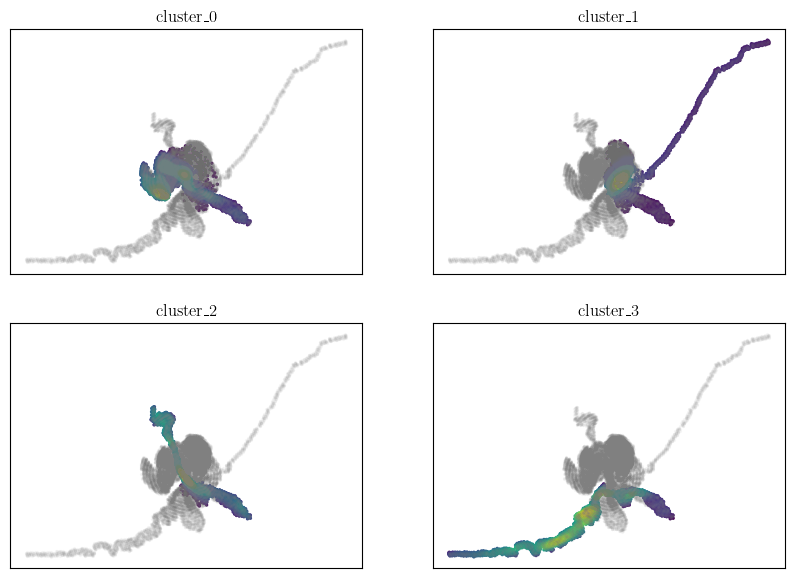

In [18]:
fig, ax = phlower.pl.plot_density_grid(adata,  figsize=(10, 7), cluster_name='trajs_clusters', bg_alpha=0.05, return_fig=True)

## Tree creating

In [19]:
phlower.tl.harmonic_stream_tree(adata, verbose=True, min_bin_number=20, min_kde_quant_rm=0.01, trim_end=False)

2025-01-14 18:41:01.634833 trajectory groups ranking...
eigen_n < 1, use knee_eigen to find the number of eigen vectors to use
eigen_n: 50
{0, 1, 2, 3}


traj bins: 100%|██████████| 4/4 [00:58<00:00, 14.57s/it]


2025-01-14 18:42:49.353899 sync bins to by pseudo time...
2025-01-14 18:42:49.765746 calculating distances between bin pairs...
2025-01-14 18:42:50.011717 fate tree creating...
[(0, 1, 2, 3)]
2025-01-14 18:42:50.012303 tree attributes adding...
2025-01-14 18:42:51.286191 plugin to STREAM...
2025-01-14 18:42:51.290195 projecting trajs to harmonic...
2025-01-14 18:43:36.229265 cumsum...
2025-01-14 18:43:39.484656 edge cumsum dict...


edges projection: 100%|██████████| 9844/9844 [00:42<00:00, 234.34it/s]


2025-01-14 18:44:33.938307 done...
there are 1444 nodes not visited in the tree
will approximate the node cumsum coordinate by 5 nearest accessible neighbors
2025-01-14 18:45:07.457487 done...


## stream plot

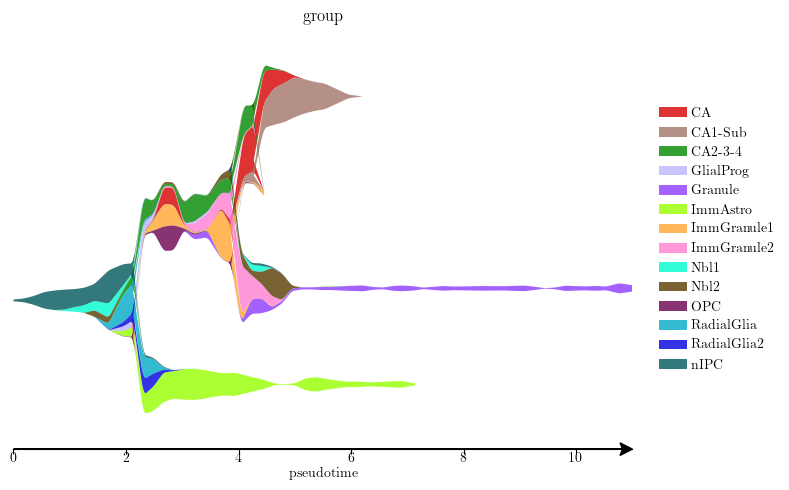

In [20]:
phlower.ext.plot_stream(adata, fig_size=(8,5), dist_scale=1, log_scale=True, factor_min_win=1, factor_num_win=5, show_legend=True)

In [21]:
pickle.dump(adata, open("save/hip_phlower_final.pickle", 'wb'))

In [22]:
import session_info
session_info.show()